In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import neighbors
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

C:\Users\fengy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Define some metrics function
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

### 1. Load in data

In [3]:
df_store = pd.read_csv('store.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

C:\Users\fengy\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_store.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [5]:
df_train.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [6]:
df_test.head(2)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0


### 2. Data cleaning & Building Feature

In [7]:
# Adding time columns
df_train.fillna(0, inplace = True)
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train['Month'] = df_train.Date.apply(lambda dt: dt.month)
df_train['Year'] = df_train.Date.apply(lambda dt: dt.year)
df_train['Day'] = df_train.Date.apply(lambda dt: dt.day)
df_train['wom'] = df_train.Date.apply(lambda dt: (dt.day-1)//7 + 1)
df_train['SchoolHoliday'] = df_train['SchoolHoliday'].astype(int) 
df_train['Open'] = df_train['Open'].map(lambda x : float(x))
df_train = df_train.merge(df_store,  on = 'Store')

df_test.fillna(0, inplace=True)
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test['Month'] = df_test.Date.apply(lambda dt: dt.month)
df_test['Year'] = df_test.Date.apply(lambda dt: dt.year)
df_test['Day'] = df_test.Date.apply(lambda dt: dt.day)
df_test['wom'] = df_test.Date.apply(lambda dt: (dt.day-1)//7 + 1)
df_test['SchoolHoliday'] = df_test['SchoolHoliday'].astype(int) 
df_test = df_test.merge(df_store,  on = 'Store')

In [8]:
# add previous time period data
df_train['prev_wom'] = df_train.groupby(['Month','DayOfWeek','wom','Store'])['Sales'].shift(1)
df_train['prev_wom'].fillna(df_train['Sales'],inplace=True)

In [9]:
# Create another test dataset from train dataset (the previous year )
from datetime import datetime
for_test = df_train[(df_train["Date"]>=datetime(2014,7,1)) & \
                    (df_train["Date"]<=datetime(2014,9,30))]

for_test = for_test[['Month','DayOfWeek','wom','Store','Sales']]
for_test.columns = ['Month','DayOfWeek','wom','Store','prev_wom']
df_test = pd.merge(df_test,for_test,how='left', \
                   on=['Month','DayOfWeek','wom','Store'])

In [10]:
for_test_na = df_train.groupby('Store')['prev_wom'].median().reset_index()
for_test_na.columns = ['Store','prev_wom_change']
df_test = pd.merge(df_test,for_test_na,how='left',on=['Store'])

In [11]:
df_test.loc[df_test['prev_wom'].isnull(),'prev_wom']=df_test['prev_wom_change']
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Month,Year,...,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,prev_wom,prev_wom_change
0,1,1,4,2015-09-17,1.0,1,0,0,9,2015,...,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3740.0,4209.0
1,857,1,3,2015-09-16,1.0,1,0,0,9,2015,...,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,4383.0,4209.0
2,1713,1,2,2015-09-15,1.0,1,0,0,9,2015,...,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,4381.0,4209.0
3,2569,1,1,2015-09-14,1.0,1,0,0,9,2015,...,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3676.0,4209.0
4,3425,1,7,2015-09-13,0.0,0,0,0,9,2015,...,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,0.0,4209.0


In [12]:
# Deal with some categorical variables

# Store Type
df_train.loc[df_train['StoreType'] == 'a', 'StoreType'] = '1'
df_train.loc[df_train['StoreType'] == 'b', 'StoreType'] = '2'
df_train.loc[df_train['StoreType'] == 'c', 'StoreType'] = '3'
df_train.loc[df_train['StoreType'] == 'd', 'StoreType'] = '4'

df_test.loc[df_test['StoreType'] == 'a', 'StoreType'] = '1'
df_test.loc[df_test['StoreType'] == 'b', 'StoreType'] = '2'
df_test.loc[df_test['StoreType'] == 'c', 'StoreType'] = '3'
df_test.loc[df_test['StoreType'] == 'd', 'StoreType'] = '4'

# Assortment
df_train.loc[df_train['Assortment'] == 'a', 'Assortment'] = '1'
df_train.loc[df_train['Assortment'] == 'b', 'Assortment'] = '2'
df_train.loc[df_train['Assortment'] == 'c', 'Assortment'] = '3'

df_test.loc[df_test['Assortment'] == 'a', 'Assortment'] = '1'
df_test.loc[df_test['Assortment'] == 'b', 'Assortment'] = '2'
df_test.loc[df_test['Assortment'] == 'c', 'Assortment'] = '3'

# Stateholiday
df_train['StateHoliday'] = df_train['StateHoliday'].replace(0, '0')
df_train.loc[df_train['StateHoliday'] == 'a', 'StateHoliday'] = '1'
df_train.loc[df_train['StateHoliday'] == 'b', 'StateHoliday'] = '2'
df_train.loc[df_train['StateHoliday'] == 'c', 'StateHoliday'] = '3'

df_test['StateHoliday'] = df_test['StateHoliday'].replace(0, '0')
df_test.loc[df_test['StateHoliday'] == 'a', 'StateHoliday'] = '1'
df_test.loc[df_test['StateHoliday'] == 'b', 'StateHoliday'] = '2'
df_test.loc[df_test['StateHoliday'] == 'c', 'StateHoliday'] = '3'

# Promote interval
df_train.loc[df_train['PromoInterval'].isnull(), 'PromoInterval'] = '1'
df_train.loc[df_train['PromoInterval'] == 'Jan,Apr,Jul,Oct', 'PromoInterval'] = '2'
df_train.loc[df_train['PromoInterval'] == 'Feb,May,Aug,Nov', 'PromoInterval'] = '3'
df_train.loc[df_train['PromoInterval'] == 'Mar,Jun,Sept,Dec', 'PromoInterval'] = '4'


df_test.loc[df_test['PromoInterval'].isnull(), 'PromoInterval'] = '1'
df_test.loc[df_test['PromoInterval'] == 'Jan,Apr,Jul,Oct', 'PromoInterval'] = '2'
df_test.loc[df_test['PromoInterval'] == 'Feb,May,Aug,Nov', 'PromoInterval'] = '3'
df_test.loc[df_test['PromoInterval'] == 'Mar,Jun,Sept,Dec', 'PromoInterval'] = '4'

In [13]:
# Create the column of store average sales (using train dataset)
df_train_custsales = df_train[['Store','Customers','Sales']]

mean_data = df_train_custsales.groupby('Store'). \
            agg({'Sales':'mean','Customers':'mean'}).reset_index()

df_train = df_train.merge(mean_data, on = 'Store')
df_test = df_test.merge(mean_data, on = 'Store')

In [14]:
# Distance data
df_train['CompetitionDistance'].fillna(df_train['CompetitionDistance'].median(), inplace=True)
df_train['CompetitionDistance'] = np.log(df_train.CompetitionDistance) + 1

df_test['CompetitionDistance'].fillna(df_test['CompetitionDistance'].median(), inplace=True)
df_test['CompetitionDistance'] = np.log(df_test.CompetitionDistance) + 1

In [15]:
# Only the open days 
df_train = df_train[df_train["Open"] != 0]

In [16]:
# Drop useless columns
df_train = df_train[df_train.columns.drop(['Day','Store','Date','CompetitionOpenSinceMonth', \
                                           'CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval','Year'])]

df_test = df_test[df_test.columns.drop(['Day','Store','Date','CompetitionOpenSinceMonth', \
                                        'CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval','Year'])]

In [17]:
# Create Dummies
df_train = pd.get_dummies(df_train, columns=['DayOfWeek', 'StateHoliday', \
                                             'StoreType', 'Assortment','Month'], dummy_na=False)

df_test = pd.get_dummies(df_test, columns=['DayOfWeek', 'StateHoliday', \
                                           'StoreType', 'Assortment','Month'], dummy_na=False)

In [18]:
# adding test the same column just like train does
df_test['StateHoliday_2']=0
df_test['StateHoliday_3']=0

df_test['Month_1'] = 0
df_test['Month_2'] = 0
df_test['Month_3'] = 0
df_test['Month_4'] = 0
df_test['Month_5'] = 0
df_test['Month_6'] = 0
df_test['Month_7'] = 0
df_test['Month_10'] = 0
df_test['Month_11'] = 0
df_test['Month_12'] = 0

In [19]:
df_test.head()

,Id,Open,Promo,SchoolHoliday,wom,CompetitionDistance,Promo2,prev_wom,prev_wom_change,Sales,...,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_10,Month_11,Month_12
0,1,1.0,1,0,3,8.146772,0,3740.0,4209.0,3945.704883,...,0,0,0,0,0,0,0,0,0,0
1,857,1.0,1,0,3,8.146772,0,4383.0,4209.0,3945.704883,...,0,0,0,0,0,0,0,0,0,0
2,1713,1.0,1,0,3,8.146772,0,4381.0,4209.0,3945.704883,...,0,0,0,0,0,0,0,0,0,0
3,2569,1.0,1,0,2,8.146772,0,3676.0,4209.0,3945.704883,...,0,0,0,0,0,0,0,0,0,0
4,3425,0.0,0,0,2,8.146772,0,0.0,4209.0,3945.704883,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Create target and independent variables
y = df_train['Sales_x']

df_train = df_train.drop(["Sales_x",  "Customers_x"],axis=1)

id_order = df_test['Id']

df_test = df_test.drop(["Id"],axis=1)

df_train = df_train.rename(index=str, columns={"Sales_y": "Sales", "Customers_y": "Customers"})

df_test = df_test[df_train.columns]

In [21]:
df_train.columns

Index(['Open', 'Promo', 'SchoolHoliday', 'wom', 'CompetitionDistance',
       'Promo2', 'prev_wom', 'Sales', 'Customers', 'DayOfWeek_1',
       'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5',
       'DayOfWeek_6', 'DayOfWeek_7', 'StateHoliday_0', 'StateHoliday_1',
       'StateHoliday_2', 'StateHoliday_3', 'StoreType_1', 'StoreType_2',
       'StoreType_3', 'StoreType_4', 'Assortment_1', 'Assortment_2',
       'Assortment_3', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12'],
      dtype='object')

In [22]:
df_test.columns

Index(['Open', 'Promo', 'SchoolHoliday', 'wom', 'CompetitionDistance',
       'Promo2', 'prev_wom', 'Sales', 'Customers', 'DayOfWeek_1',
       'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5',
       'DayOfWeek_6', 'DayOfWeek_7', 'StateHoliday_0', 'StateHoliday_1',
       'StateHoliday_2', 'StateHoliday_3', 'StoreType_1', 'StoreType_2',
       'StoreType_3', 'StoreType_4', 'Assortment_1', 'Assortment_2',
       'Assortment_3', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12'],
      dtype='object')

### 3. Test Train Split and Normalization

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.05, \
                                                    random_state=1)

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

### 4. Model Building

#### Linear/Ridge/Lasso

In [25]:
lin_reg = linear_model.LinearRegression()
d_tree = lin_reg
d_tree.fit(X_train_std, y_train)
y_pred_lin = d_tree.predict(X_test_std)

In [26]:
(r2_score(y_test,y_pred_lin), rmspe(y_pred_lin,y_test))

(0.8369841880716797, 0.24077248127641881)

In [27]:
ridge_reg = linear_model.Ridge()
lasso_reg = linear_model.Lasso()

In [28]:
ridge_reg.fit(X_train_std, y_train)
lasso_reg.fit(X_train_std, y_train)
y_pred_ridge = ridge_reg.predict(X_test_std)
y_pred_lasso = lasso_reg.predict(X_test_std)

In [29]:
(r2_score(y_test,y_pred_ridge), rmspe(y_pred_ridge,y_test))

(0.8369870338392521, 0.24083345894516156)

In [30]:
(r2_score(y_test,y_pred_lasso), rmspe(y_pred_lasso,y_test))

(0.8369680296131354, 0.24060942401659802)

#### Decision Tree

In [31]:
d_tree = DecisionTreeRegressor()
d_tree.fit(X_train, y_train)
y_pred_tree = d_tree.predict(X_test)

In [32]:
(r2_score(y_test,y_pred_tree), rmspe(y_pred_tree,y_test))

(0.8424290662502762, 0.22871736658341935)

#### KNN

In [ ]:
knn_st = neighbors.KNeighborsRegressor(n_neighbors=5)
knn_st.fit(X_train_std, y_train)
y_pred_knnst = knn_st.predict(X_test_std)

In [ ]:
(r2_score(y_test,y_pred_knnst), rmspe(y_pred_knnst,y_test))

#### Random Forest

In [33]:
clf_rf = RandomForestRegressor(random_state=123) 
clf_rf.fit(X_train_std, y_train)
y_pred_rf = clf_rf.predict(X_test_std)

In [34]:
(r2_score(y_test,y_pred_rf), rmspe(y_pred_rf,y_test))

(0.8979439369248127, 0.20233909101300013)

#### Gradient Boosting

In [35]:
gb = GradientBoostingRegressor(random_state=123) 

In [36]:
gb.fit(X_train_std, y_train)
y_pred_gb = gb.predict(X_test_std)

In [37]:
(r2_score(y_test,y_pred_gb), rmspe(y_pred_gb,y_test))

(0.8859208211335522, 0.20921159073209736)

#### Sequental Neural Network

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from livelossplot import PlotLossesKeras

In [40]:
y_train = np.array(y_train)

model = Sequential()
input_dim = X_train_std.shape[1]

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [41]:
model.add(Dense(5, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

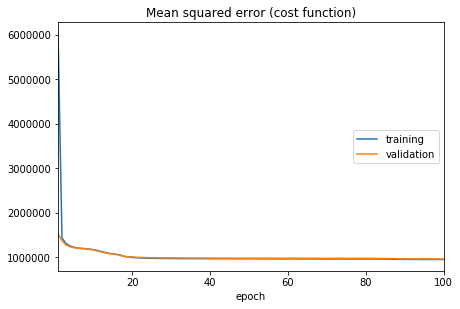

Mean squared error (cost function):
training   (min: 944331.567, max: 6016067.220, cur: 944331.567)
validation (min: 954905.620, max: 1514322.280, cur: 954905.620)


In [42]:
model.fit(X_train_std, y_train, batch_size = 20, \
          epochs = 100,validation_split=0.2, callbacks=[PlotLossesKeras()], \
          verbose=1)

In [43]:
y_pred = model.predict(X_test_std)

In [44]:
(r2_score(y_test, y_pred), rmspe(y_pred.flatten(),y_test))

(0.9015612951877684, 0.20268189708684567)

#### SVR

In [ ]:
svr = SVR(kernel='linear')
svr.fit(X_train_std, y_train)
y_pred_svr = svr.predict(X_test_std)

In [ ]:
(r2_score(y_test,y_pred_svr), rmspe(y_pred_svr,y_test))

#### Stacking

In [45]:
lr = LinearRegression()
dtc = DecisionTreeRegressor()
rf = RandomForestRegressor()

stregr = StackingRegressor(regressors=[dtc, lr], meta_regressor=rf)
stack = stregr.fit(X_train_std, y_train)
y_pred_stack = stack.predict(X_test_std)

In [46]:
(r2_score(y_test,y_pred_stack), rmspe(y_pred_stack,y_test))

(0.8413216452141783, 0.2303344162663707)

#### Bagging

In [47]:
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor
bag = BaggingRegressor()
bag.fit(X_train_std, y_train)
y_pred_bag = bag.predict(X_test_std)

In [48]:
(r2_score(y_test,y_pred_bag), rmspe(y_pred_bag,y_test))

(0.8969294364824312, 0.19702412048685583)

#### XGBoosting

In [49]:
# Use log on target column y
dtrain = xgb.DMatrix(X_train, np.log(y_train + 1))
dvalid = xgb.DMatrix(X_test, np.log(y_test + 1))
dtest = xgb.DMatrix(df_test)

In [50]:
# Taking parameters
params = {"objective": "reg:linear",
          "eta": 0.3,
          "max_depth": 7,
          "subsample": 0.75,
          "colsample_bytree": 0.7,
          "silent": 1
          }

num_trees = 400

watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

In [51]:
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, \
                early_stopping_rounds=50, feval=rmspe_xg, verbose_eval=True)

[0]	eval-rmse:5.79028	train-rmse:5.78982	eval-rmspe:0.99689	train-rmspe:0.996879
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:4.05614	train-rmse:4.05548	eval-rmspe:0.982052	train-rmspe:0.98203
[2]	eval-rmse:2.84244	train-rmse:2.84173	eval-rmspe:0.939991	train-rmspe:0.939936
[3]	eval-rmse:1.99373	train-rmse:1.99301	eval-rmspe:0.860629	train-rmspe:0.860512
[4]	eval-rmse:1.40157	train-rmse:1.40086	eval-rmspe:0.748833	train-rmspe:0.748594
[5]	eval-rmse:0.987595	train-rmse:0.986974	eval-rmspe:0.622089	train-rmspe:0.621621
[6]	eval-rmse:0.700776	train-rmse:0.700311	eval-rmspe:0.498718	train-rmspe:0.497765
[7]	eval-rmse:0.503094	train-rmse:0.502873	eval-rmspe:0.392375	train-rmspe:0.390929
[8]	eval-rmse:0.368737	train-rmse:0.368789	eval-rmspe:0.309863	train-rmspe:0.306175
[9]	eval-rmse:0.279126	train-rmse:0.279529	eval-rmspe:0.252062	train-rmspe:0.245644
[10]	eval-rmse:0.222374	t

[96]	eval-rmse:0.135237	train-rmse:0.12977	eval-rmspe:0.177258	train-rmspe:0.137353
[97]	eval-rmse:0.135412	train-rmse:0.129652	eval-rmspe:0.177292	train-rmspe:0.137343
[98]	eval-rmse:0.135373	train-rmse:0.129567	eval-rmspe:0.177241	train-rmspe:0.137281
[99]	eval-rmse:0.135323	train-rmse:0.129395	eval-rmspe:0.177156	train-rmspe:0.137162
[100]	eval-rmse:0.135272	train-rmse:0.129324	eval-rmspe:0.177128	train-rmspe:0.137094
[101]	eval-rmse:0.135195	train-rmse:0.129241	eval-rmspe:0.177082	train-rmspe:0.137018
[102]	eval-rmse:0.135134	train-rmse:0.129169	eval-rmspe:0.177013	train-rmspe:0.136926
[103]	eval-rmse:0.135195	train-rmse:0.129013	eval-rmspe:0.177348	train-rmspe:0.136652
[104]	eval-rmse:0.135188	train-rmse:0.128992	eval-rmspe:0.177329	train-rmspe:0.136609
[105]	eval-rmse:0.135206	train-rmse:0.128975	eval-rmspe:0.177357	train-rmspe:0.136591
[106]	eval-rmse:0.135203	train-rmse:0.128909	eval-rmspe:0.177366	train-rmspe:0.136528
[107]	eval-rmse:0.135194	train-rmse:0.12889	eval-rmspe:0.17

[192]	eval-rmse:0.134068	train-rmse:0.124436	eval-rmspe:0.177738	train-rmspe:0.133234
[193]	eval-rmse:0.134097	train-rmse:0.124431	eval-rmspe:0.177778	train-rmspe:0.133212
[194]	eval-rmse:0.134088	train-rmse:0.1244	eval-rmspe:0.177747	train-rmspe:0.133183
[195]	eval-rmse:0.134089	train-rmse:0.12436	eval-rmspe:0.1777	train-rmspe:0.133162
[196]	eval-rmse:0.134085	train-rmse:0.124346	eval-rmspe:0.177699	train-rmspe:0.133134
[197]	eval-rmse:0.134082	train-rmse:0.124331	eval-rmspe:0.177691	train-rmspe:0.133113
[198]	eval-rmse:0.134078	train-rmse:0.124303	eval-rmspe:0.177752	train-rmspe:0.133098
[199]	eval-rmse:0.134033	train-rmse:0.124283	eval-rmspe:0.177706	train-rmspe:0.133028
[200]	eval-rmse:0.134032	train-rmse:0.124232	eval-rmspe:0.177799	train-rmspe:0.132995
[201]	eval-rmse:0.134007	train-rmse:0.124232	eval-rmspe:0.177774	train-rmspe:0.132988
[202]	eval-rmse:0.133979	train-rmse:0.124211	eval-rmspe:0.177697	train-rmspe:0.132978
[203]	eval-rmse:0.133994	train-rmse:0.124198	eval-rmspe:0.1

[288]	eval-rmse:0.134572	train-rmse:0.120396	eval-rmspe:0.178228	train-rmspe:0.125381
[289]	eval-rmse:0.134582	train-rmse:0.120391	eval-rmspe:0.178348	train-rmspe:0.125391
[290]	eval-rmse:0.134635	train-rmse:0.120364	eval-rmspe:0.178364	train-rmspe:0.125343
[291]	eval-rmse:0.134629	train-rmse:0.120348	eval-rmspe:0.178386	train-rmspe:0.125289
[292]	eval-rmse:0.134618	train-rmse:0.12032	eval-rmspe:0.178356	train-rmspe:0.125253
[293]	eval-rmse:0.134609	train-rmse:0.120272	eval-rmspe:0.178348	train-rmspe:0.125211
[294]	eval-rmse:0.134606	train-rmse:0.120256	eval-rmspe:0.178346	train-rmspe:0.125193
[295]	eval-rmse:0.134607	train-rmse:0.120239	eval-rmspe:0.17845	train-rmspe:0.125202
[296]	eval-rmse:0.134591	train-rmse:0.120213	eval-rmspe:0.178361	train-rmspe:0.125147
[297]	eval-rmse:0.134581	train-rmse:0.120191	eval-rmspe:0.178345	train-rmspe:0.125119
[298]	eval-rmse:0.134573	train-rmse:0.120138	eval-rmspe:0.178319	train-rmspe:0.125069
[299]	eval-rmse:0.134601	train-rmse:0.120081	eval-rmspe:

[384]	eval-rmse:0.135098	train-rmse:0.118362	eval-rmspe:0.178167	train-rmspe:0.121483
[385]	eval-rmse:0.135095	train-rmse:0.118343	eval-rmspe:0.178044	train-rmspe:0.121442
[386]	eval-rmse:0.135068	train-rmse:0.118307	eval-rmspe:0.178041	train-rmspe:0.121418
[387]	eval-rmse:0.135069	train-rmse:0.11829	eval-rmspe:0.178077	train-rmspe:0.121408
[388]	eval-rmse:0.135073	train-rmse:0.118252	eval-rmspe:0.178066	train-rmspe:0.12139
[389]	eval-rmse:0.135079	train-rmse:0.118239	eval-rmspe:0.178118	train-rmspe:0.121381
[390]	eval-rmse:0.135128	train-rmse:0.118155	eval-rmspe:0.178128	train-rmspe:0.121365
[391]	eval-rmse:0.135136	train-rmse:0.118174	eval-rmspe:0.17812	train-rmspe:0.121346
[392]	eval-rmse:0.135164	train-rmse:0.118188	eval-rmspe:0.178189	train-rmspe:0.121343
[393]	eval-rmse:0.135173	train-rmse:0.118184	eval-rmspe:0.178193	train-rmspe:0.121328
[394]	eval-rmse:0.135182	train-rmse:0.118136	eval-rmspe:0.178191	train-rmspe:0.121304
[395]	eval-rmse:0.135163	train-rmse:0.118107	eval-rmspe:0

In [52]:
validation_response = gbm.predict(xgb.DMatrix(X_test))
invalid_sales = validation_response < 0
validation_response[invalid_sales] = 0

In [53]:
rmspe(np.exp(validation_response) - 1, y_test)

0.17815169563770591